In [ ]:
# referências:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/
# https://www.kaggle.com/code/ishanharshvardhan/time-series-analysis-and-forecasting-using-arima
# https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/2-ARIMA/README.md

In [345]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import numpy as np
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd
from dtw import *
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

### Carrengando o dataset e tratando os dados e colunas não úteis

In [ ]:
fp = '../data/sst.mnmean.nc'
ds = nc.Dataset(fp)

In [56]:
ds = xr.open_dataset(fp)
df = ds.to_dataframe()

In [57]:
df = df.reset_index()
df = df[df['nbnds'] == 0] # Garante que há apenas uma medição por área por tempo
df = df.drop('nbnds', axis='columns')
df = df.drop('time_bnds', axis='columns')

In [23]:
#print(df['lat'].unique())
#print(df['lon'].unique())

In [58]:
df.head()

,lat,lon,time,sst
0,88.0,0.0,1854-01-01,-1.8
2,88.0,0.0,1854-02-01,-1.8
4,88.0,0.0,1854-03-01,-1.8
6,88.0,0.0,1854-04-01,-1.8
8,88.0,0.0,1854-05-01,-1.8


### Funções úteis

In [74]:
# setando column_name como índice do dataframe
def set_dataframe_index(df: pd.DataFrame, column_name: str):
    return df.set_index(column_name)

def get_date_and_temperature_from(df: pd.DataFrame, lat: int, lon: int):
    return df[(df['lat'] == lat) & (df['lon'] == lon)]

f_inv = lambda x: x + 180
f = lambda x: ((x+180) % 360) - 180

In [76]:
#setando a culuna tempo como índice do dataframe
df = set_dataframe_index(df, 'time')
df.head()

,lat,lon,sst
time,,,
1854-01-01,88.0,0.0,-1.8
1854-02-01,88.0,0.0,-1.8
1854-03-01,88.0,0.0,-1.8
1854-04-01,88.0,0.0,-1.8
1854-05-01,88.0,0.0,-1.8


### Pegando a temperatura de um ponto no dataset

In [86]:
df_sst_lat_lon = get_date_and_temperature_from(df, 32.0, 16.0)

# os pontos definidos de latitude e longitude
# lat = 20°, lon = -132°
#df_sst_enso = get_date_and_temperature_from(df, f_inv(20.0), f_inv(-132.0))

# lat = -22°, lon = -72°
#df_sst_chile = get_date_and_temperature_from(df, f_inv(-22.0), f_inv(-72.0))

# lat = 36°, lon = 18°
#df_sst_medit = get_date_and_temperature_from(df, f_inv(36.0), f_inv(18.0))

# lat = 0°, lon = -22°
#df_sst_atlantico = get_date_and_temperature_from(df, f_inv(0.0), f_inv(-22.0))

# lat = -56°, lon = 80°
#df_sst_indico = get_date_and_temperature_from(df, f_inv(-56.0), f_inv(80.0))


In [174]:
df_sst_lat_lon.head()

,lat,lon,sst
time,,,
1854-01-01,32.0,16.0,17.333422
1854-02-01,32.0,16.0,16.721617
1854-03-01,32.0,16.0,16.491089
1854-04-01,32.0,16.0,17.444820
1854-05-01,32.0,16.0,19.150229


### Plotando a temperatura de um ponto do dataset atravéz do tempo

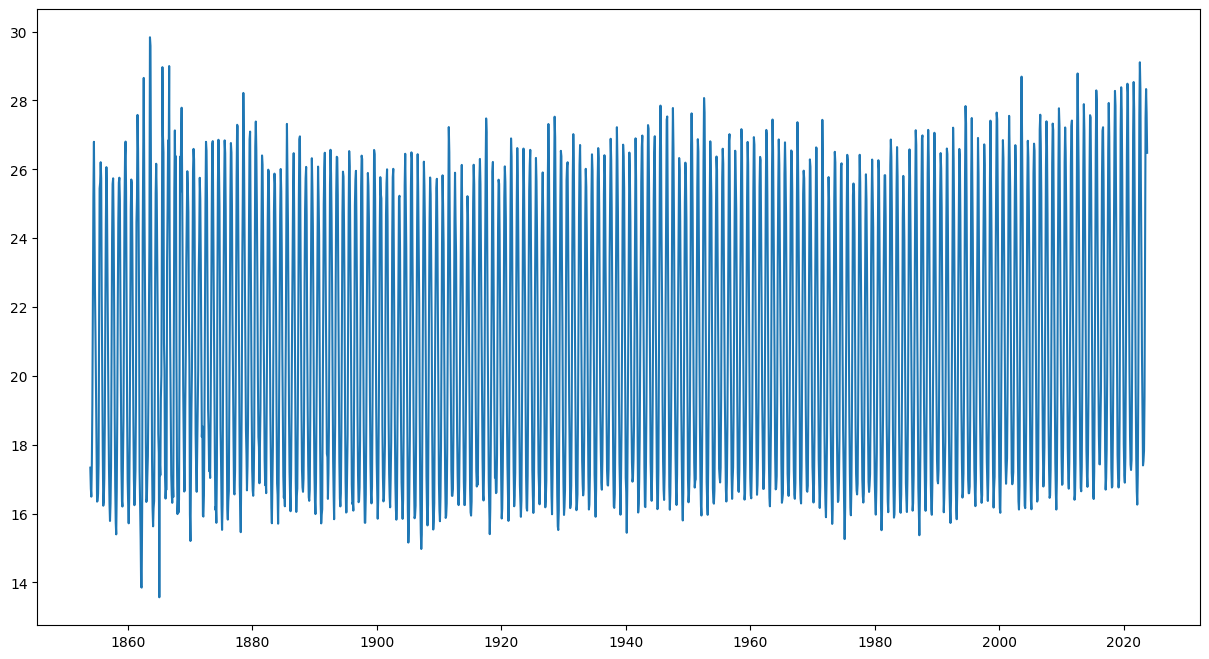

In [127]:
index = df_sst_lat_lon.index.tolist()
plt.figure(figsize=(15,8))
plt.plot(index,df_sst_lat_lon['sst'])
plt.show()

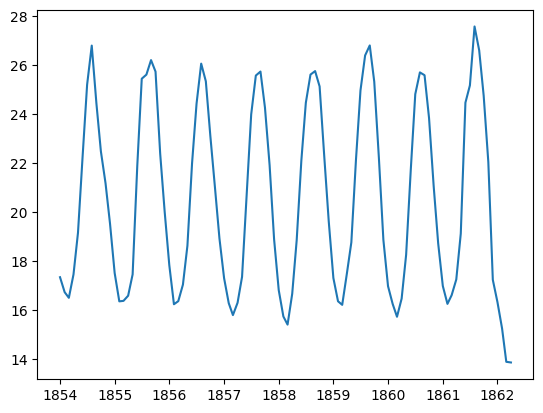

In [175]:
#plotando a temperatura do ponto atravéz do tempo para as primeiras 100 leituras
index = df_sst_lat_lon.index.tolist()
plt.plot(index[:100],df_sst_lat_lon['sst'][:100])
plt.show()

In [196]:
#from pandas import read_csv
#from pandas import datetime
#from statsmodels.tsa.arima.model import ARIMA
#from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from math import sqrt

### Criando os datasets de treino e teste

In [416]:
# separa em treino e teste
X = df_sst_lat_lon['sst'].to_frame()
#X = df.columns.get_indexer(['sst'])
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)
test_shifted.index

Training data shape:  (1630, 1)
Test data shape:  (408, 1)


DatetimeIndex(['1991-07-01', '1991-08-01', '1991-09-01', '1991-10-01',
               '1991-11-01', '1991-12-01', '1992-01-01', '1992-02-01',
               '1992-03-01', '1992-04-01',
               ...
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01'],
              dtype='datetime64[ns]', length=384, freq='MS')

In [417]:
# fazendo o pandas inferir a frequencia do índice #MS=month start frequency para esse dataset
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
test.index = pd.DatetimeIndex(test.index.values, freq=test.index.inferred_freq)
train.index 

DatetimeIndex(['1854-01-01', '1854-02-01', '1854-03-01', '1854-04-01',
               '1854-05-01', '1854-06-01', '1854-07-01', '1854-08-01',
               '1854-09-01', '1854-10-01',
               ...
               '1989-01-01', '1989-02-01', '1989-03-01', '1989-04-01',
               '1989-05-01', '1989-06-01', '1989-07-01', '1989-08-01',
               '1989-09-01', '1989-10-01'],
              dtype='datetime64[ns]', length=1630, freq='MS')

### Implementando o ARIMA/SARIMA

An ARIMA, which stands for AutoRegressive Integrated Moving Average, model can be created using the statsmodels library. In the next section, we perform the following steps:

    Define the model by calling SARIMAX() and passing in the model parameters: p, d, and q parameters, and P, D, and Q parameters.
    The model is prepared on the training data by calling the fit() function.
    Predictions can be made by calling the forecast() function and specifying the number of steps (horizon) which to forecast

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are:

    p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.
    d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
    q is the parameter associated with the moving average part of the model.

If our model has a seasonal component, we use a seasonal ARIMA model (SARIMA). In that case we have another set of parameters: P, D, and Q which describe the same associations as p,d, and q, but correspond with the seasonal components of the model.


### Otimizando os parâmetros para o SARIMA

In [418]:
#https://alkaline-ml.com/pmdarima/0.9.0/setup.html#setup
#from pyramid.arima import auto_arima

In [419]:
# referênica 
# https://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html

# Procura pelos melhores parâmetros (order e seasonal_order)
#Even after differencing the data by 24 hours (the seasonal frequency), we still see a seasonal trend in the data.
#Selecting the best parameters for an Arima model can be challenging - somewhat subjective and time intesive, 
#so we'll leave it as an exercise to the user. We used an auto_arima() function to search a provided space of 
#parameters for the best model.

''''''
auto_tune = False

if (auto_tune):
    auto_model = auto_arima(train, start_p=1, start_q=0,
                               max_p=5, max_q=0, m=24,
                               start_P=0, max_P=2,Q=0, 
                               seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    print(auto_model.aic())
    print(auto_model.summary())
''''''

''

### Treinando o modelo com o dataset de treino

Aqui depois de obter os parâmetros `order` e `seadonal_order` do otimizador **auto_arima** do bloco anterior

In [420]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                sst   No. Observations:                 1630
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1346.681
Date:                            Thu, 23 Nov 2023   AIC                           2703.362
Time:                                    01:50:06   BIC                           2730.304
Sample:                                01-01-1854   HQIC                          2713.361
                                     - 10-01-1989                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4785      0.016     30.707      0.000       0.448       0.509
ma.L1         -0.9782      0.007   

### Plotando a distribuição dos erros resíduais

Média zero nos resíduos indica que não há viéis na predição.

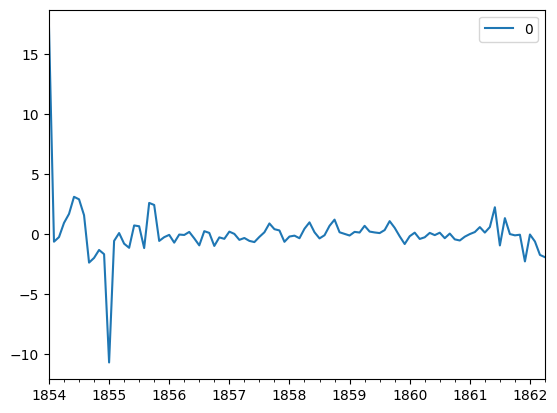

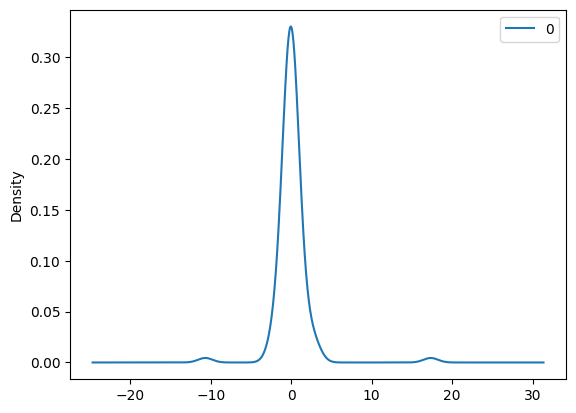

                0
count  100.000000
mean     0.084453
std      2.256246
min    -10.684026
25%     -0.428358
50%     -0.023543
75%      0.279378
max     17.333422


In [421]:
# plot residual errors
residuals = pd.DataFrame(results.resid[0:100])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

###  Avaliação do modelo

Será realizada uma **walk-forward validation** que é muito boa para usar em projetos próprios de forecasting de séries temporais.

Primeiro, o modelo é treinado com o dataset de treino. Então, é realizada a predição no próximo passo em que a predição é avaliada em contraste com o valor conhecido. O dataset de treino é expandido para incluir o novo valor conhecido e o processo é repetido. 

Na prática o modelo SARIMAX é re-treinado em cada iteração do loop assim que novos pontos do histórico ficam disponíveis.

Re-treinar o modelo a cada iteração torna a predição mais robusta, entretanto, aumenta o custo computacional de ter esses vários modelos.


In [422]:
HORIZONTE = 5 #numero de meses à frente para prever
test_shifted = test.copy()

for t in range(1, HORIZONTE):
    test_shifted['sst+'+str(t)] = test_shifted['sst'].shift(-t, freq='MS')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.tail(5)

,sst,sst+1,sst+2,sst+3,sst+4
2023-02-01,17.399174,17.524534,17.822731,19.385254,23.629042
2023-03-01,17.524534,17.822731,19.385254,23.629042,27.487192
2023-04-01,17.822731,19.385254,23.629042,27.487192,28.331211
2023-05-01,19.385254,23.629042,27.487192,28.331211,27.635229
2023-06-01,23.629042,27.487192,28.331211,27.635229,26.480513


In [442]:
training_window = 96 # meses de janela de treino (8 anos) 

train_ts = train['sst']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):] #da data atual para anterior

#print(history)
#print(train['sst'])
#train_ts.head()

In [436]:
%%time
predictions = list()
for t in range(test_ts.shape[0]):
    if t > 400:
        #https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
        model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps = HORIZONTE)
        predictions.append(yhat)
        observation = list(test_ts.iloc[t])

        # move the training window
        history.append(observation[0])
        history.pop(0)
#     if t < 10:
#     print(obs)
        print(t+1, '. Predicting time step: ', test_ts.index[t])
        print(t+1, ': predicted =', yhat)
        print(t+1, ': expected  =', observation)
        print('----------')
#     else:
#         break

402 . Predicting time step:  2023-04-01 00:00:00
402 : predicted = [24.2776878  21.55332943 18.95503951 17.12805049 16.34918351]
402 : expected  = [17.822731018066406, 19.38525390625, 23.62904167175293, 27.487192153930664, 28.33121109008789]
----------
403 . Predicting time step:  2023-05-01 00:00:00
403 : predicted = [17.1628034  14.4567221  12.94324002 12.23741071 12.17421502]
403 : expected  = [19.38525390625, 23.62904167175293, 27.487192153930664, 28.33121109008789, 27.635229110717773]
----------
404 . Predicting time step:  2023-06-01 00:00:00
404 : predicted = [15.23127055 14.67404764 13.3976736  13.69915122 13.91095022]
404 : expected  = [23.62904167175293, 27.487192153930664, 28.33121109008789, 27.635229110717773, 26.480512619018555]
----------
CPU times: total: 5.17 s
Wall time: 1.13 s


In [392]:

#rmse = sqrt(mean_squared_error(test_ts[0], predictions))
#print('Test RMSE: %.3f' % rmse)
print(history)
print(list(test_ts.iloc(0)[0]))

[18.60357093811035, 17.371280670166016, 16.36150360107422, 16.0394229888916, 16.948408126831055, 18.74690055847168, 22.80404281616211, 26.11394500732422, 26.865442276000977, 26.36675453186035, 24.815174102783203, 21.345659255981445, 18.458276748657227, 16.79283905029297, 15.881938934326172, 15.97900676727295, 16.877845764160156, 19.235593795776367, 22.28993797302246, 25.3609561920166, 26.64569854736328, 25.792261123657227, 23.762964248657227, 21.18793487548828, 18.41461944580078, 16.7922306060791, 16.06034278869629, 16.021764755249023, 16.55886459350586, 18.36317253112793, 21.014358520507812, 24.57965660095215, 25.808591842651367, 25.146745681762695, 23.943950653076172, 21.724933624267578, 19.179912567138672, 16.881824493408203, 16.38294792175293, 16.04549217224121, 16.998260498046875, 18.79793930053711, 22.263608932495117, 25.263214111328125, 26.57936668395996, 25.784793853759766, 24.1390323638916, 21.684656143188477, 19.20078468322754, 17.224498748779297, 16.0841121673584, 16.3068103

In [443]:
# eval_df = pd.DataFrame(predictions, columns=['sst+'+str(t) for t in range(1, HORIZON+1)])
# eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
# eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
# eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
# eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
# eval_df.head()

### Fazendo testes independentes

In [441]:
# separa em treino e teste
X = df_sst_lat_lon['sst'].to_frame()
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = train
#print(len(X))
#print(len(train))
#print(len(test))
#print(len(history))

test.iloc[0]
# # walk-forward validation
# predictions = []
# for t in range(len(test)):
#     model = SARIMAX(history,
#             order=(1, 1, 1),
#             seasonal_order=(0, 1, 1, 12),
#             enforce_invertibility=False)
    
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test.iloc[t]
#     history.append(obs)
#     if t < 10:
#         print('predicted=%f, expected=%f' % (yhat, obs))
#     else:
#         break
# #print(predictions)
# # evaluate forecasts
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)
# # plot forecasts against actual outcomes
# #plt.plot(test)
# #plt.plot(predictions, color='red')
# #plt.show()

sst    21.295662
Name: 1989-11-01 00:00:00, dtype: float32

In [384]:
print(model_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6722      0.125      5.390      0.000       0.428       0.917
ma.L1         -0.9952      0.962     -1.034      0.301      -2.882       0.891
ar.S.L12       0.0776      0.197      0.393      0.694      -0.309       0.464
ma.S.L12      -0.9975     21.412     -0.047      0.963     -42.964      40.969
sigma2         0.1060      2.247      0.047      0.962      -4.298       4.510


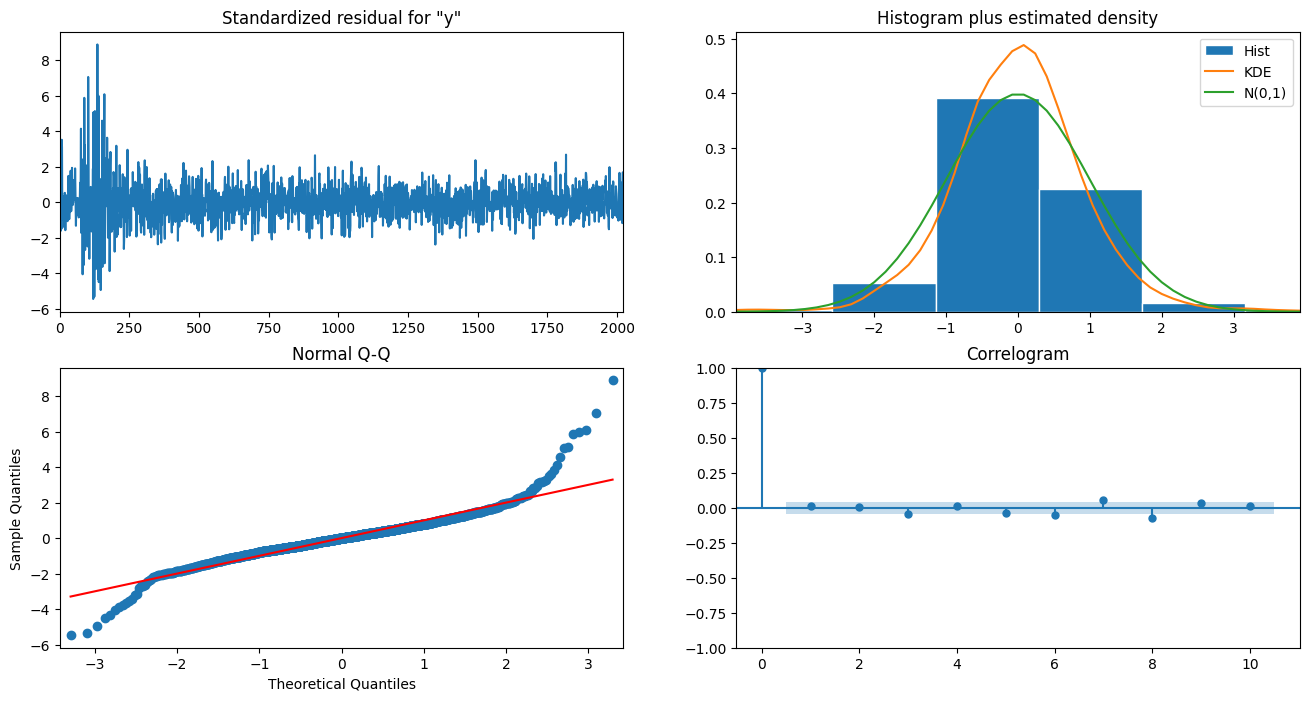

In [40]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()